In [ ]:
# NAME: Abhijit Hanumeswara Kulkarni
# GITHUB USERNAME: abhijithanumeswarakulkarni
# USC ID: 5367018274

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Imports
import os
from collections import defaultdict
from PIL import Image
import random
import shutil
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.losses import CategoricalCrossentropy

import warnings
warnings.filterwarnings("ignore")

1. Transfer Learning for Image Classification <br />
It is highly recommended that you complete this project using Keras1 and Python. <br />
(a) In this problem, we are trying to build a classifier that distinguishes images of nine types of waste.

In [3]:
recycle_repo_path = '/content/drive/MyDrive/DSML_Project/data/RealWaste'
waste_categories = sorted(os.listdir(recycle_repo_path))
print(f"Identified {len(waste_categories)} waste types:\n{waste_categories}")

bin_counts = {}
visual_dims = defaultdict(set)
file_encodings = defaultdict(set)

for waste_type in waste_categories:
    category_path = os.path.join(recycle_repo_path, waste_type)
    bin_items = sorted(os.listdir(category_path))
    bin_counts[waste_type] = len(bin_items)
    for visual_file in bin_items[:5]:
        image_path = os.path.join(category_path, visual_file)
        try:
            with Image.open(image_path) as visual:
                visual_dims[waste_type].add(visual.size)
                file_encodings[waste_type].add(visual.format)
        except Exception as issue:
            print(f"Unreadable image at {image_path}: {issue}")

print("\n📊 Waste Dataset Summary:")
for category in waste_categories:
    print(f"{category}: {bin_counts[category]} images | Shapes: {visual_dims[category]} | Formats: {file_encodings[category]}")

Identified 9 waste types:
['1-Cardboard', '2-Food Organics', '3-Glass', '4-Metal', '5-Miscellaneous Trash', '6-Paper', '7-Plastic', '8-Textile Trash', '9-Vegetation']

📊 Waste Dataset Summary:
1-Cardboard: 461 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
2-Food Organics: 411 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
3-Glass: 420 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
4-Metal: 790 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
5-Miscellaneous Trash: 495 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
6-Paper: 500 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
7-Plastic: 921 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
8-Textile Trash: 318 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
9-Vegetation: 436 images | Shapes: {(524, 524)} | Formats: {'JPEG'}


(b) Data Exploration and Pre-processing <br />
i. Images are numbered in each folder. Select the first 80% of the images in each folder as your training set and the rest as the test set. You can encode your classes using one-hot encoding.

In [4]:
source_dir = '/content/drive/MyDrive/DSML_Project/data/RealWaste'
train_root = '/content/recycle_trainset'
test_root = '/content/recycle_testset'

for folder in [train_root, test_root]:
    for waste_label in waste_categories:
        os.makedirs(os.path.join(folder, waste_label), exist_ok=True)

for waste_label in waste_categories:
    origin_path = os.path.join(source_dir, waste_label)
    contents = sorted(os.listdir(origin_path))
    random.shuffle(contents)
    cutoff = int(0.8 * len(contents))
    train_files = contents[:cutoff]
    test_files = contents[cutoff:]

    for f in train_files:
        shutil.copyfile(os.path.join(origin_path, f), os.path.join(train_root, waste_label, f))
    for f in test_files:
        shutil.copyfile(os.path.join(origin_path, f), os.path.join(test_root, waste_label, f))

ii. In case all the images do not have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [5]:
resize_dim = (224, 224)

def preprocess_folder(source_root, target_root):
    for label_name in waste_categories:
        input_dir = os.path.join(source_root, label_name)
        output_dir = os.path.join(target_root, label_name)
        os.makedirs(output_dir, exist_ok=True)
        for img_file in sorted(os.listdir(input_dir)):
            src_path = os.path.join(input_dir, img_file)
            dst_path = os.path.join(output_dir, img_file)
            try:
                raw = cv2.imread(src_path)
                resized = cv2.resize(raw, resize_dim, interpolation=cv2.INTER_AREA)
                cv2.imwrite(dst_path, resized)
            except:
                pass

preprocess_folder(train_root, '/content/recycle_train_resized')
preprocess_folder(test_root, '/content/recycle_test_resized')

(c) Transfer Learning <br />
i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. In this project, you will use pre-trained models ResNet50, ResNet100, EfficientNetB0, and VGG16. For those pre-trained networks, you will only
train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the
penultimate layer in the original pre-trained model as the features extracted from each image. <br />

(ii) To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV. <br />

(iii) Use ReLU activation functions in the last layer and a softmax layer, along with L2 regularization, batch normalization 3, and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable. <br />

(iv) iv. Train the networks for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Use a randomly selected subset of 20% of each class as the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs. <br />

(v) Report training, validation, and test Precision, Recall, AUC, and F1 score for those models. Is there a model that clearly outperforms others? Remember that this is a multi-class classification problem.

In [6]:
augmented_loader = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    shear_range=0.05,
    horizontal_flip=True,
    brightness_range=(0.9, 1.1),
    fill_mode='nearest'
)

aug_train_flow = augmented_loader.flow_from_directory(
    '/content/recycle_train_resized',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='training'
)

aug_val_flow = augmented_loader.flow_from_directory(
    '/content/recycle_train_resized',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='validation'
)

res_eval = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    '/content/recycle_test_resized',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=False
)

Found 3042 images belonging to 9 classes.
Found 756 images belonging to 9 classes.
Found 954 images belonging to 9 classes.


In [7]:
base_extractor = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_extractor.layers:
    layer.trainable = False

x = base_extractor.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
out_layer = Dense(9, activation='softmax')(x)

res_model = Model(inputs=base_extractor.input, outputs=out_layer)
res_model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss=CategoricalCrossentropy(label_smoothing=0.1),
                  metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [8]:
checkpoint_path = '/content/best_resnet50_augmented_model.h5'

halt = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
saver = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)

history_aug_resnet50 = res_model.fit(
    aug_train_flow,
    epochs=50,
    validation_data=aug_val_flow,
    callbacks=[halt, saver],
    verbose=1
)

Epoch 1/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.2742 - loss: 6.9711

381/381 ━━━━━━━━━━━━━━━━━━━━ 74s 156ms/step - accuracy: 0.2746 - loss: 6.9699 - val_accuracy: 0.6045 - val_loss: 5.9072
Epoch 2/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5829 - loss: 5.8342

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.5829 - loss: 5.8339 - val_accuracy: 0.6442 - val_loss: 5.5669
Epoch 3/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6661 - loss: 5.3843

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.6660 - loss: 5.3842 - val_accuracy: 0.6680 - val_loss: 5.2893
Epoch 4/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6704 - loss: 5.1266

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.6704 - loss: 5.1264 - val_accuracy: 0.6680 - val_loss: 5.0198
Epoch 5/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7042 - loss: 4.8254

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7042 - loss: 4.8253 - val_accuracy: 0.6865 - val_loss: 4.7309
Epoch 6/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7264 - loss: 4.5464

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7264 - loss: 4.5462 - val_accuracy: 0.6971 - val_loss: 4.4989
Epoch 7/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7523 - loss: 4.2626

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7523 - loss: 4.2625 - val_accuracy: 0.7090 - val_loss: 4.2319
Epoch 8/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7565 - loss: 4.0406

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7565 - loss: 4.0404 - val_accuracy: 0.7090 - val_loss: 4.0504
Epoch 9/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7910 - loss: 3.7636

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7910 - loss: 3.7635 - val_accuracy: 0.7262 - val_loss: 3.8061
Epoch 10/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7988 - loss: 3.5499

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7988 - loss: 3.5498 - val_accuracy: 0.7169 - val_loss: 3.6047
Epoch 11/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8232 - loss: 3.3494

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8232 - loss: 3.3493 - val_accuracy: 0.7077 - val_loss: 3.4607
Epoch 12/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8088 - loss: 3.1926

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8088 - loss: 3.1925 - val_accuracy: 0.7090 - val_loss: 3.2749
Epoch 13/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8148 - loss: 2.9974

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.8148 - loss: 2.9973 - val_accuracy: 0.7328 - val_loss: 3.1272
Epoch 14/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8211 - loss: 2.8354

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8211 - loss: 2.8353 - val_accuracy: 0.7262 - val_loss: 2.9749
Epoch 15/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8369 - loss: 2.6698

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8369 - loss: 2.6698 - val_accuracy: 0.7315 - val_loss: 2.8293
Epoch 16/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8366 - loss: 2.5464

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8366 - loss: 2.5463 - val_accuracy: 0.7275 - val_loss: 2.6781
Epoch 17/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8459 - loss: 2.4137

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8459 - loss: 2.4136 - val_accuracy: 0.7447 - val_loss: 2.5536
Epoch 18/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8419 - loss: 2.3070

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.8419 - loss: 2.3070 - val_accuracy: 0.7460 - val_loss: 2.4684
Epoch 19/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8518 - loss: 2.1791

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8518 - loss: 2.1790 - val_accuracy: 0.7341 - val_loss: 2.3577
Epoch 20/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8496 - loss: 2.0804

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8496 - loss: 2.0803 - val_accuracy: 0.7288 - val_loss: 2.2723
Epoch 21/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8548 - loss: 2.0004

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8548 - loss: 2.0003 - val_accuracy: 0.7315 - val_loss: 2.1996
Epoch 22/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8779 - loss: 1.8836

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8778 - loss: 1.8836 - val_accuracy: 0.7328 - val_loss: 2.1146
Epoch 23/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8737 - loss: 1.7988

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8737 - loss: 1.7988 - val_accuracy: 0.7262 - val_loss: 2.0639
Epoch 24/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8717 - loss: 1.7346

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8717 - loss: 1.7346 - val_accuracy: 0.7328 - val_loss: 1.9909
Epoch 25/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8743 - loss: 1.6835

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.8743 - loss: 1.6835 - val_accuracy: 0.7222 - val_loss: 1.9837
Epoch 26/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8835 - loss: 1.5971

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8834 - loss: 1.5971 - val_accuracy: 0.7354 - val_loss: 1.8616
Epoch 27/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8612 - loss: 1.5689

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8612 - loss: 1.5689 - val_accuracy: 0.7249 - val_loss: 1.8504
Epoch 28/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8826 - loss: 1.4930

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.8826 - loss: 1.4930 - val_accuracy: 0.7262 - val_loss: 1.7987
Epoch 29/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8841 - loss: 1.4563

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8841 - loss: 1.4563 - val_accuracy: 0.7434 - val_loss: 1.7377
Epoch 30/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8650 - loss: 1.4401

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8650 - loss: 1.4401 - val_accuracy: 0.7354 - val_loss: 1.7169
Epoch 31/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9056 - loss: 1.3574

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.9056 - loss: 1.3575 - val_accuracy: 0.7381 - val_loss: 1.6790
Epoch 32/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8908 - loss: 1.3501

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8908 - loss: 1.3501 - val_accuracy: 0.7302 - val_loss: 1.6533
Epoch 33/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8920 - loss: 1.3238

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8920 - loss: 1.3239 - val_accuracy: 0.7487 - val_loss: 1.6187
Epoch 34/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8875 - loss: 1.2931

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.8875 - loss: 1.2931 - val_accuracy: 0.7526 - val_loss: 1.5830
Epoch 35/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8829 - loss: 1.2676

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8829 - loss: 1.2676 - val_accuracy: 0.7553 - val_loss: 1.5530
Epoch 36/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8747 - loss: 1.2577

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8747 - loss: 1.2577 - val_accuracy: 0.7606 - val_loss: 1.5478
Epoch 37/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8789 - loss: 1.2366

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.8789 - loss: 1.2366 - val_accuracy: 0.7474 - val_loss: 1.5439
Epoch 38/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8832 - loss: 1.2172

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8832 - loss: 1.2172 - val_accuracy: 0.7407 - val_loss: 1.5185
Epoch 39/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9027 - loss: 1.1781

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.9027 - loss: 1.1781 - val_accuracy: 0.7606 - val_loss: 1.4871
Epoch 40/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.8932 - loss: 1.1661 - val_accuracy: 0.7421 - val_loss: 1.4907
Epoch 41/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.9021 - loss: 1.1383 - val_accuracy: 0.7381 - val_loss: 1.4900
Epoch 42/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9124 - loss: 1.1184

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 130ms/step - accuracy: 0.9124 - loss: 1.1184 - val_accuracy: 0.7381 - val_loss: 1.4604
Epoch 43/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9036 - loss: 1.1245

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.9036 - loss: 1.1245 - val_accuracy: 0.7434 - val_loss: 1.4462
Epoch 44/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9122 - loss: 1.0880

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.9122 - loss: 1.0880 - val_accuracy: 0.7447 - val_loss: 1.4333
Epoch 45/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9082 - loss: 1.0947

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.9082 - loss: 1.0947 - val_accuracy: 0.7447 - val_loss: 1.4071
Epoch 46/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9050 - loss: 1.0791

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.9050 - loss: 1.0791 - val_accuracy: 0.7526 - val_loss: 1.3860
Epoch 47/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.9054 - loss: 1.0656 - val_accuracy: 0.7394 - val_loss: 1.3974
Epoch 48/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8904 - loss: 1.0880 - val_accuracy: 0.7540 - val_loss: 1.4012
Epoch 49/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.8979 - loss: 1.0776 - val_accuracy: 0.7513 - val_loss: 1.4046
Epoch 50/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.9009 - loss: 1.0713 - val_accuracy: 0.7209 - val_loss: 1.4152


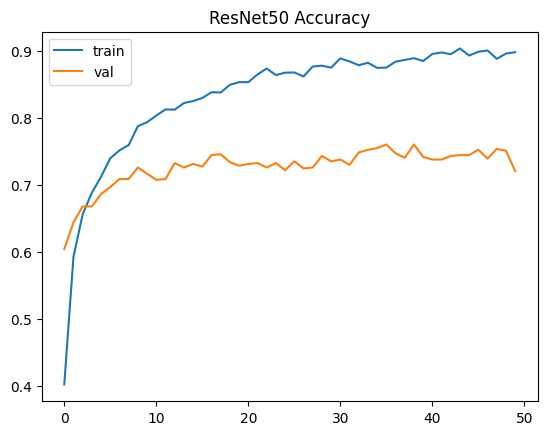

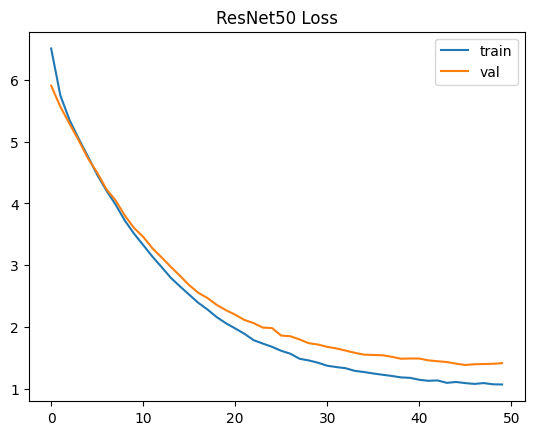

In [9]:
plt.plot(history_aug_resnet50.history['accuracy'], label='train')
plt.plot(history_aug_resnet50.history['val_accuracy'], label='val')
plt.title('ResNet50 Accuracy')
plt.legend()
plt.show()

plt.plot(history_aug_resnet50.history['loss'], label='train')
plt.plot(history_aug_resnet50.history['val_loss'], label='val')
plt.title('ResNet50 Loss')
plt.legend()
plt.show()

In [11]:
# Training set evaluations
train_eval_flow = augmented_loader.flow_from_directory(
    '/content/recycle_train_resized',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='training',
    shuffle=False
)

train_eval_flow.reset()
true_labels = train_eval_flow.classes
predicted_probs = res_model.predict(train_eval_flow, verbose=1)
predicted_labels = np.argmax(predicted_probs, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=train_eval_flow.class_indices.keys()))

macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
macro_prec = precision_score(true_labels, predicted_labels, average='macro')
macro_recall = recall_score(true_labels, predicted_labels, average='macro')
onehot_labels = np.eye(9)[true_labels]
macro_auc = roc_auc_score(onehot_labels, predicted_probs, multi_class='ovr', average='macro')

print(f'Train F1: {macro_f1:.4f} | Precision: {macro_prec:.4f} | Recall: {macro_recall:.4f} | AUC: {macro_auc:.4f}')

Found 3042 images belonging to 9 classes.
381/381 ━━━━━━━━━━━━━━━━━━━━ 38s 100ms/step
                       precision    recall  f1-score   support

          1-Cardboard       1.00      0.99      0.99       295
      2-Food Organics       0.99      1.00      0.99       263
              3-Glass       0.99      0.98      0.98       269
              4-Metal       0.98      1.00      0.99       506
5-Miscellaneous Trash       0.99      0.99      0.99       317
              6-Paper       1.00      0.99      1.00       320
            7-Plastic       0.98      0.98      0.98       589
      8-Textile Trash       1.00      0.99      1.00       204
         9-Vegetation       1.00      0.99      0.99       279

             accuracy                           0.99      3042
            macro avg       0.99      0.99      0.99      3042
         weighted avg       0.99      0.99      0.99      3042

Train F1: 0.9911 | Precision: 0.9919 | Recall: 0.9902 | AUC: 0.9998


In [12]:
# Validation set evaluations
aug_eval_flow = aug_val_flow
aug_eval_flow.reset()
true_labels = aug_eval_flow.classes
predicted_probs = res_model.predict(aug_eval_flow, verbose=1)
predicted_labels = np.argmax(predicted_probs, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=aug_eval_flow.class_indices.keys()))

macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
macro_prec = precision_score(true_labels, predicted_labels, average='macro')
macro_recall = recall_score(true_labels, predicted_labels, average='macro')
onehot_labels = np.eye(9)[true_labels]
macro_auc = roc_auc_score(onehot_labels, predicted_probs, multi_class='ovr', average='macro')

print(f'Val F1: {macro_f1:.4f} | Precision: {macro_prec:.4f} | Recall: {macro_recall:.4f} | AUC: {macro_auc:.4f}')

95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.13      0.10      0.11        73
      2-Food Organics       0.07      0.06      0.06        65
              3-Glass       0.08      0.07      0.08        67
              4-Metal       0.13      0.15      0.14       126
5-Miscellaneous Trash       0.13      0.13      0.13        79
              6-Paper       0.23      0.21      0.22        80
            7-Plastic       0.22      0.23      0.23       147
      8-Textile Trash       0.07      0.08      0.07        50
         9-Vegetation       0.11      0.12      0.11        69

             accuracy                           0.14       756
            macro avg       0.13      0.13      0.13       756
         weighted avg       0.14      0.14      0.14       756

Val F1: 0.1283 | Precision: 0.1299 | Recall: 0.1277 | AUC: 0.5078


In [13]:
# Test set evaluations
res_eval.reset()
true_labels = res_eval.classes
predicted_probs = res_model.predict(res_eval, verbose=1)
predicted_labels = np.argmax(predicted_probs, axis=1)
print(classification_report(true_labels, predicted_labels, target_names=res_eval.class_indices.keys()))

macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
macro_prec = precision_score(true_labels, predicted_labels, average='macro')
macro_recall = recall_score(true_labels, predicted_labels, average='macro')
onehot_labels = np.eye(9)[true_labels]
macro_auc = roc_auc_score(onehot_labels, predicted_probs, multi_class='ovr', average='macro')

print(f'F1: {macro_f1:.4f} | Precision: {macro_prec:.4f} | Recall: {macro_recall:.4f} | AUC: {macro_auc:.4f}')

120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.77      0.86      0.81        93
      2-Food Organics       0.92      0.92      0.92        83
              3-Glass       0.89      0.85      0.87        84
              4-Metal       0.81      0.94      0.87       158
5-Miscellaneous Trash       0.82      0.77      0.79        99
              6-Paper       0.90      0.87      0.88       100
            7-Plastic       0.88      0.78      0.83       185
      8-Textile Trash       0.89      0.84      0.86        64
         9-Vegetation       0.96      0.97      0.96        88

             accuracy                           0.86       954
            macro avg       0.87      0.87      0.87       954
         weighted avg       0.86      0.86      0.86       954

F1: 0.8658 | Precision: 0.8688 | Recall: 0.8655 | AUC: 0.9866


In [14]:
res101_base = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in res101_base.layers:
    layer.trainable = False

z = res101_base.output
z = GlobalAveragePooling2D()(z)
z = BatchNormalization()(z)
z = Dropout(0.3)(z)
z = Dense(256, activation='relu', kernel_regularizer='l2')(z)
z = BatchNormalization()(z)
z = Dropout(0.3)(z)
res101_out = Dense(9, activation='softmax')(z)

res101_model = Model(inputs=res101_base.input, outputs=res101_out)
res101_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [15]:
res101_ckpt = '/content/best_resnet101_augmented_model.h5'

early_stop_101 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_save_101 = ModelCheckpoint(filepath=res101_ckpt, monitor='val_loss', save_best_only=True)

res101_history = res101_model.fit(
    aug_train_flow,
    epochs=50,
    validation_data=aug_val_flow,
    callbacks=[early_stop_101, model_save_101],
    verbose=1
)

Epoch 1/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.2958 - loss: 6.9428

381/381 ━━━━━━━━━━━━━━━━━━━━ 84s 170ms/step - accuracy: 0.2961 - loss: 6.9416 - val_accuracy: 0.5807 - val_loss: 5.8871
Epoch 2/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5839 - loss: 5.8490

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.5840 - loss: 5.8488 - val_accuracy: 0.6283 - val_loss: 5.6115
Epoch 3/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6543 - loss: 5.4201

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.6543 - loss: 5.4200 - val_accuracy: 0.6680 - val_loss: 5.2569
Epoch 4/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7052 - loss: 5.0754

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.7052 - loss: 5.0754 - val_accuracy: 0.6786 - val_loss: 5.0081
Epoch 5/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7076 - loss: 4.8367

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - accuracy: 0.7076 - loss: 4.8366 - val_accuracy: 0.6905 - val_loss: 4.7492
Epoch 6/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7364 - loss: 4.5328

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - accuracy: 0.7364 - loss: 4.5327 - val_accuracy: 0.7024 - val_loss: 4.4959
Epoch 7/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7587 - loss: 4.2463

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.7587 - loss: 4.2461 - val_accuracy: 0.7116 - val_loss: 4.2403
Epoch 8/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7595 - loss: 4.0472

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.7595 - loss: 4.0471 - val_accuracy: 0.7024 - val_loss: 4.0590
Epoch 9/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7844 - loss: 3.7716

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.7844 - loss: 3.7715 - val_accuracy: 0.6971 - val_loss: 3.8318
Epoch 10/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7652 - loss: 3.5959

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.7652 - loss: 3.5957 - val_accuracy: 0.7275 - val_loss: 3.6332
Epoch 11/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8005 - loss: 3.3907

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.8005 - loss: 3.3906 - val_accuracy: 0.7315 - val_loss: 3.4167
Epoch 12/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8127 - loss: 3.1524

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.8126 - loss: 3.1523 - val_accuracy: 0.7116 - val_loss: 3.2791
Epoch 13/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8190 - loss: 2.9969

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 130ms/step - accuracy: 0.8189 - loss: 2.9968 - val_accuracy: 0.7354 - val_loss: 3.1220
Epoch 14/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8193 - loss: 2.8470

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.8193 - loss: 2.8470 - val_accuracy: 0.7116 - val_loss: 2.9988
Epoch 15/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8368 - loss: 2.6679

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.8368 - loss: 2.6678 - val_accuracy: 0.7593 - val_loss: 2.8143
Epoch 16/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8166 - loss: 2.5629

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.8166 - loss: 2.5628 - val_accuracy: 0.7249 - val_loss: 2.7091
Epoch 17/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8334 - loss: 2.4223

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 130ms/step - accuracy: 0.8334 - loss: 2.4222 - val_accuracy: 0.7394 - val_loss: 2.5948
Epoch 18/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8262 - loss: 2.3212

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.8262 - loss: 2.3211 - val_accuracy: 0.7434 - val_loss: 2.4892
Epoch 19/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8582 - loss: 2.1725

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.8582 - loss: 2.1725 - val_accuracy: 0.7235 - val_loss: 2.4029
Epoch 20/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8587 - loss: 2.0825

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.8587 - loss: 2.0824 - val_accuracy: 0.7275 - val_loss: 2.3140
Epoch 21/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8450 - loss: 2.0097

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.8450 - loss: 2.0096 - val_accuracy: 0.7434 - val_loss: 2.2175
Epoch 22/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8574 - loss: 1.8940

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.8574 - loss: 1.8939 - val_accuracy: 0.7235 - val_loss: 2.1553
Epoch 23/50
380/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8633 - loss: 1.8171

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.8633 - loss: 1.8171 - val_accuracy: 0.7394 - val_loss: 2.0391
Epoch 24/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8487 - loss: 1.7692

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.8487 - loss: 1.7691 - val_accuracy: 0.7434 - val_loss: 1.9835
Epoch 25/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8741 - loss: 1.6840

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.8740 - loss: 1.6840 - val_accuracy: 0.7381 - val_loss: 1.9401
Epoch 26/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8586 - loss: 1.6428

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.8586 - loss: 1.6427 - val_accuracy: 0.7500 - val_loss: 1.8652
Epoch 27/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8667 - loss: 1.5974

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - accuracy: 0.8667 - loss: 1.5974 - val_accuracy: 0.7275 - val_loss: 1.8206
Epoch 28/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8672 - loss: 1.5442

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.8672 - loss: 1.5442 - val_accuracy: 0.7421 - val_loss: 1.7896
Epoch 29/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8708 - loss: 1.4867

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 130ms/step - accuracy: 0.8708 - loss: 1.4867 - val_accuracy: 0.7222 - val_loss: 1.7512
Epoch 30/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8816 - loss: 1.4185

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.8816 - loss: 1.4185 - val_accuracy: 0.7553 - val_loss: 1.6944
Epoch 31/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8729 - loss: 1.4008

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.8729 - loss: 1.4008 - val_accuracy: 0.7407 - val_loss: 1.6491
Epoch 32/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8852 - loss: 1.3593

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.8852 - loss: 1.3593 - val_accuracy: 0.7500 - val_loss: 1.6307
Epoch 33/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9029 - loss: 1.2990

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 130ms/step - accuracy: 0.9028 - loss: 1.2990 - val_accuracy: 0.7579 - val_loss: 1.5959
Epoch 34/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.8919 - loss: 1.2835 - val_accuracy: 0.7288 - val_loss: 1.6095
Epoch 35/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8887 - loss: 1.2713

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.8887 - loss: 1.2712 - val_accuracy: 0.7460 - val_loss: 1.5373
Epoch 36/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8890 - loss: 1.2479

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.8890 - loss: 1.2479 - val_accuracy: 0.7619 - val_loss: 1.4983
Epoch 37/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8917 - loss: 1.2198

381/381 ━━━━━━━━━━━━━━━━━━━━ 51s 133ms/step - accuracy: 0.8917 - loss: 1.2198 - val_accuracy: 0.7579 - val_loss: 1.4801
Epoch 38/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.8983 - loss: 1.1866 - val_accuracy: 0.7434 - val_loss: 1.5223
Epoch 39/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9108 - loss: 1.1656

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - accuracy: 0.9107 - loss: 1.1657 - val_accuracy: 0.7474 - val_loss: 1.4685
Epoch 40/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8944 - loss: 1.1730

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.8944 - loss: 1.1730 - val_accuracy: 0.7553 - val_loss: 1.4462
Epoch 41/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.8793 - loss: 1.1732 - val_accuracy: 0.7368 - val_loss: 1.4649
Epoch 42/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.8963 - loss: 1.1337 - val_accuracy: 0.7341 - val_loss: 1.4515
Epoch 43/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9019 - loss: 1.1204

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.9019 - loss: 1.1205 - val_accuracy: 0.7659 - val_loss: 1.4203
Epoch 44/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8948 - loss: 1.1190

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.8948 - loss: 1.1190 - val_accuracy: 0.7698 - val_loss: 1.4140
Epoch 45/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8938 - loss: 1.1090

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - accuracy: 0.8938 - loss: 1.1090 - val_accuracy: 0.7553 - val_loss: 1.3865
Epoch 46/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.9076 - loss: 1.0864 - val_accuracy: 0.7553 - val_loss: 1.4006
Epoch 47/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9011 - loss: 1.0765

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.9011 - loss: 1.0765 - val_accuracy: 0.7725 - val_loss: 1.3856
Epoch 48/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8881 - loss: 1.0922 - val_accuracy: 0.7500 - val_loss: 1.4023
Epoch 49/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9036 - loss: 1.0565

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.9035 - loss: 1.0566 - val_accuracy: 0.7500 - val_loss: 1.3683
Epoch 50/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9074 - loss: 1.0516

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.9073 - loss: 1.0517 - val_accuracy: 0.7672 - val_loss: 1.3216


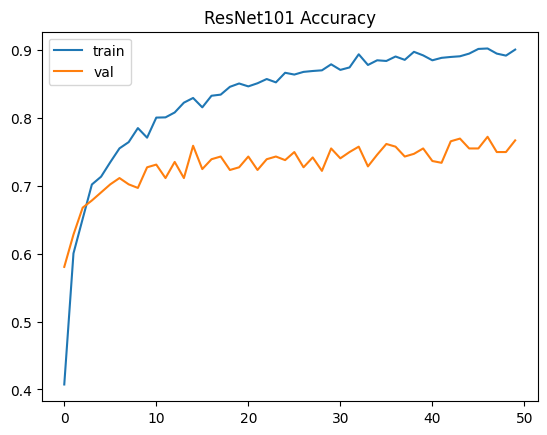

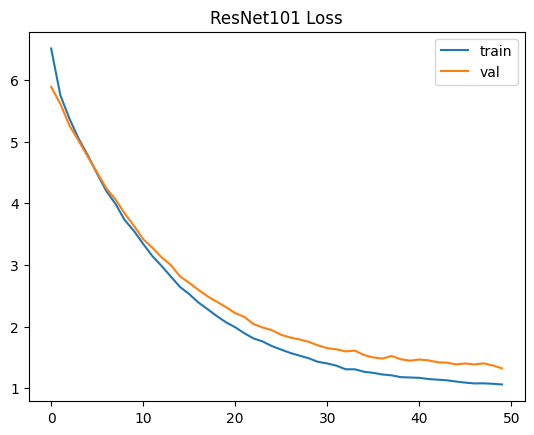

In [16]:
plt.plot(res101_history.history['accuracy'], label='train')
plt.plot(res101_history.history['val_accuracy'], label='val')
plt.title('ResNet101 Accuracy')
plt.legend()
plt.show()

plt.plot(res101_history.history['loss'], label='train')
plt.plot(res101_history.history['val_loss'], label='val')
plt.title('ResNet101 Loss')
plt.legend()
plt.show()

In [17]:
# Train set evaluations
train_eval_flow_101 = augmented_loader.flow_from_directory(
    '/content/recycle_train_resized',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='training',
    shuffle=False
)

train_eval_flow_101.reset()
true_labels_101 = train_eval_flow_101.classes
predicted_probs_101 = res101_model.predict(train_eval_flow_101, verbose=1)
predicted_labels_101 = np.argmax(predicted_probs_101, axis=1)

print(classification_report(true_labels_101, predicted_labels_101, target_names=train_eval_flow_101.class_indices.keys()))

macro_f1_101 = f1_score(true_labels_101, predicted_labels_101, average='macro')
macro_prec_101 = precision_score(true_labels_101, predicted_labels_101, average='macro')
macro_recall_101 = recall_score(true_labels_101, predicted_labels_101, average='macro')
onehot_labels_101 = np.eye(9)[true_labels_101]
macro_auc_101 = roc_auc_score(onehot_labels_101, predicted_probs_101, multi_class='ovr', average='macro')

print(f'Train F1: {macro_f1_101:.4f} | Precision: {macro_prec_101:.4f} | Recall: {macro_recall_101:.4f} | AUC: {macro_auc_101:.4f}')

Found 3042 images belonging to 9 classes.
381/381 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.99      0.98      0.99       295
      2-Food Organics       0.98      0.99      0.98       263
              3-Glass       0.98      0.99      0.99       269
              4-Metal       0.99      0.98      0.99       506
5-Miscellaneous Trash       0.99      0.98      0.99       317
              6-Paper       0.99      0.99      0.99       320
            7-Plastic       0.98      0.99      0.99       589
      8-Textile Trash       1.00      1.00      1.00       204
         9-Vegetation       0.99      0.98      0.99       279

             accuracy                           0.99      3042
            macro avg       0.99      0.99      0.99      3042
         weighted avg       0.99      0.99      0.99      3042

Train F1: 0.9887 | Precision: 0.9892 | Recall: 0.9883 | AUC: 0.9998


In [18]:
# Validation set evaluations
aug_val_flow.reset()
true_labels_101 = aug_val_flow.classes
predicted_probs_101 = res101_model.predict(aug_val_flow, verbose=1)
predicted_labels_101 = np.argmax(predicted_probs_101, axis=1)

print(classification_report(true_labels_101, predicted_labels_101, target_names=aug_val_flow.class_indices.keys()))

macro_f1_101 = f1_score(true_labels_101, predicted_labels_101, average='macro')
macro_prec_101 = precision_score(true_labels_101, predicted_labels_101, average='macro')
macro_recall_101 = recall_score(true_labels_101, predicted_labels_101, average='macro')
onehot_101 = np.eye(9)[true_labels_101]
macro_auc_101 = roc_auc_score(onehot_101, predicted_probs_101, multi_class='ovr', average='macro')

print(f'Val F1: {macro_f1_101:.4f} | Precision: {macro_prec_101:.4f} | Recall: {macro_recall_101:.4f} | AUC: {macro_auc_101:.4f}')

95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.05      0.03      0.04        73
      2-Food Organics       0.08      0.08      0.08        65
              3-Glass       0.12      0.12      0.12        67
              4-Metal       0.18      0.20      0.19       126
5-Miscellaneous Trash       0.13      0.13      0.13        79
              6-Paper       0.08      0.09      0.08        80
            7-Plastic       0.16      0.17      0.17       147
      8-Textile Trash       0.09      0.10      0.09        50
         9-Vegetation       0.10      0.10      0.10        69

             accuracy                           0.12       756
            macro avg       0.11      0.11      0.11       756
         weighted avg       0.12      0.12      0.12       756

Val F1: 0.1103 | Precision: 0.1095 | Recall: 0.1120 | AUC: 0.5001


In [19]:
# Test set evaluations
res_eval.reset()
true_labels_101 = res_eval.classes
predicted_probs_101 = res101_model.predict(res_eval, verbose=1)
predicted_labels_101 = np.argmax(predicted_probs_101, axis=1)

print(classification_report(true_labels_101, predicted_labels_101, target_names=res_eval.class_indices.keys()))

macro_f1_101 = f1_score(true_labels_101, predicted_labels_101, average='macro')
macro_prec_101 = precision_score(true_labels_101, predicted_labels_101, average='macro')
macro_recall_101 = recall_score(true_labels_101, predicted_labels_101, average='macro')
onehot_101 = np.eye(9)[true_labels_101]
macro_auc_101 = roc_auc_score(onehot_101, predicted_probs_101, multi_class='ovr', average='macro')

print(f'F1: {macro_f1_101:.4f} | Precision: {macro_prec_101:.4f} | Recall: {macro_recall_101:.4f} | AUC: {macro_auc_101:.4f}')

120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.76      0.87      0.81        93
      2-Food Organics       0.97      0.87      0.92        83
              3-Glass       0.91      0.92      0.91        84
              4-Metal       0.83      0.94      0.88       158
5-Miscellaneous Trash       0.89      0.80      0.84        99
              6-Paper       0.91      0.85      0.88       100
            7-Plastic       0.87      0.83      0.85       185
      8-Textile Trash       0.91      0.80      0.85        64
         9-Vegetation       0.91      0.98      0.95        88

             accuracy                           0.87       954
            macro avg       0.88      0.87      0.88       954
         weighted avg       0.88      0.87      0.87       954

F1: 0.8760 | Precision: 0.8844 | Recall: 0.8718 | AUC: 0.9884


In [20]:
# EfficientNetB0
eff_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in eff_base.layers:
    layer.trainable = False

e = eff_base.output
e = GlobalAveragePooling2D()(e)
e = BatchNormalization()(e)
e = Dropout(0.3)(e)
e = Dense(256, activation='relu', kernel_regularizer='l2')(e)
e = BatchNormalization()(e)
e = Dropout(0.3)(e)
eff_out = Dense(9, activation='softmax')(e)

eff_model = Model(inputs=eff_base.input, outputs=eff_out)
eff_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [21]:
eff_ckpt = '/content/best_efficientnetb0_augmented_model.h5'

early_stop_eff = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_save_eff = ModelCheckpoint(filepath=eff_ckpt, monitor='val_loss', save_best_only=True)

eff_history = eff_model.fit(
    aug_train_flow,
    epochs=50,
    validation_data=aug_val_flow,
    callbacks=[early_stop_eff, model_save_eff],
    verbose=1
)

Epoch 1/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.2233 - loss: 6.9078

381/381 ━━━━━━━━━━━━━━━━━━━━ 102s 197ms/step - accuracy: 0.2235 - loss: 6.9067 - val_accuracy: 0.4894 - val_loss: 5.7963
Epoch 2/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.4263 - loss: 5.9440

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 130ms/step - accuracy: 0.4264 - loss: 5.9436 - val_accuracy: 0.5476 - val_loss: 5.5234
Epoch 3/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.5082 - loss: 5.5508

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.5082 - loss: 5.5506 - val_accuracy: 0.5569 - val_loss: 5.2493
Epoch 4/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5692 - loss: 5.2064

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.5693 - loss: 5.2063 - val_accuracy: 0.5860 - val_loss: 5.0333
Epoch 5/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.5713 - loss: 5.0177

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.5713 - loss: 5.0176 - val_accuracy: 0.5886 - val_loss: 4.8370
Epoch 6/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6139 - loss: 4.6974

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.6139 - loss: 4.6974 - val_accuracy: 0.6217 - val_loss: 4.5912
Epoch 7/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6328 - loss: 4.4682

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.6328 - loss: 4.4681 - val_accuracy: 0.5992 - val_loss: 4.4544
Epoch 8/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6537 - loss: 4.2766

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.6537 - loss: 4.2765 - val_accuracy: 0.6177 - val_loss: 4.2392
Epoch 9/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6586 - loss: 4.0819

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.6586 - loss: 4.0818 - val_accuracy: 0.6548 - val_loss: 4.0352
Epoch 10/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6568 - loss: 3.9159

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.6569 - loss: 3.9158 - val_accuracy: 0.6389 - val_loss: 3.8785
Epoch 11/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6557 - loss: 3.7660

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.6558 - loss: 3.7658 - val_accuracy: 0.6508 - val_loss: 3.7129
Epoch 12/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6763 - loss: 3.5468

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.6763 - loss: 3.5467 - val_accuracy: 0.6548 - val_loss: 3.5617
Epoch 13/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7008 - loss: 3.4108

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.7007 - loss: 3.4107 - val_accuracy: 0.6270 - val_loss: 3.4755
Epoch 14/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6927 - loss: 3.2600

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.6927 - loss: 3.2600 - val_accuracy: 0.6429 - val_loss: 3.3179
Epoch 15/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7035 - loss: 3.1170

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.7035 - loss: 3.1169 - val_accuracy: 0.6548 - val_loss: 3.2141
Epoch 16/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7113 - loss: 2.9813

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.7113 - loss: 2.9813 - val_accuracy: 0.6534 - val_loss: 3.0698
Epoch 17/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7185 - loss: 2.8485

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.7185 - loss: 2.8485 - val_accuracy: 0.6402 - val_loss: 3.0031
Epoch 18/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7209 - loss: 2.7662

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.7209 - loss: 2.7662 - val_accuracy: 0.6296 - val_loss: 2.8630
Epoch 19/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7498 - loss: 2.6064

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - accuracy: 0.7497 - loss: 2.6064 - val_accuracy: 0.6825 - val_loss: 2.7865
Epoch 20/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7136 - loss: 2.5581

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.7136 - loss: 2.5581 - val_accuracy: 0.6601 - val_loss: 2.6809
Epoch 21/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7278 - loss: 2.4619

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.7278 - loss: 2.4618 - val_accuracy: 0.6521 - val_loss: 2.6227
Epoch 22/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7421 - loss: 2.3742

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.7421 - loss: 2.3742 - val_accuracy: 0.6706 - val_loss: 2.5229
Epoch 23/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7366 - loss: 2.3110

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.7366 - loss: 2.3109 - val_accuracy: 0.6759 - val_loss: 2.4513
Epoch 24/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7326 - loss: 2.2304

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.7327 - loss: 2.2304 - val_accuracy: 0.6653 - val_loss: 2.3982
Epoch 25/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7416 - loss: 2.1474

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - accuracy: 0.7416 - loss: 2.1474 - val_accuracy: 0.6892 - val_loss: 2.3281
Epoch 26/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7431 - loss: 2.1047

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.7431 - loss: 2.1047 - val_accuracy: 0.6759 - val_loss: 2.2549
Epoch 27/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7431 - loss: 2.0431

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.7431 - loss: 2.0430 - val_accuracy: 0.6693 - val_loss: 2.2355
Epoch 28/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7436 - loss: 1.9780

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.7436 - loss: 1.9780 - val_accuracy: 0.6799 - val_loss: 2.1254
Epoch 29/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7781 - loss: 1.8958

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.7780 - loss: 1.8958 - val_accuracy: 0.6653 - val_loss: 2.1042
Epoch 30/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7537 - loss: 1.8684

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.7537 - loss: 1.8683 - val_accuracy: 0.6706 - val_loss: 2.0669
Epoch 31/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7720 - loss: 1.7956

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.7720 - loss: 1.7956 - val_accuracy: 0.6799 - val_loss: 2.0242
Epoch 32/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.7664 - loss: 1.7682 - val_accuracy: 0.6548 - val_loss: 2.0302
Epoch 33/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7528 - loss: 1.7735

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.7528 - loss: 1.7734 - val_accuracy: 0.6786 - val_loss: 1.9682
Epoch 34/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7796 - loss: 1.7070

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.7796 - loss: 1.7070 - val_accuracy: 0.6799 - val_loss: 1.9161
Epoch 35/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7651 - loss: 1.6854

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.7651 - loss: 1.6854 - val_accuracy: 0.6812 - val_loss: 1.8662
Epoch 36/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7721 - loss: 1.6355

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 130ms/step - accuracy: 0.7721 - loss: 1.6355 - val_accuracy: 0.6772 - val_loss: 1.8435
Epoch 37/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.7872 - loss: 1.5861 - val_accuracy: 0.6706 - val_loss: 1.8550
Epoch 38/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.7759 - loss: 1.5637 - val_accuracy: 0.6481 - val_loss: 1.8559
Epoch 39/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7760 - loss: 1.5466

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - accuracy: 0.7760 - loss: 1.5466 - val_accuracy: 0.6495 - val_loss: 1.8288
Epoch 40/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7784 - loss: 1.5238

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.7783 - loss: 1.5238 - val_accuracy: 0.6508 - val_loss: 1.7947
Epoch 41/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7964 - loss: 1.4632

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - accuracy: 0.7964 - loss: 1.4632 - val_accuracy: 0.6614 - val_loss: 1.7355
Epoch 42/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.7823 - loss: 1.4742 - val_accuracy: 0.6561 - val_loss: 1.7436
Epoch 43/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7968 - loss: 1.4457

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.7968 - loss: 1.4457 - val_accuracy: 0.6746 - val_loss: 1.7078
Epoch 44/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7926 - loss: 1.4257

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.7926 - loss: 1.4258 - val_accuracy: 0.6905 - val_loss: 1.6693
Epoch 45/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.7832 - loss: 1.4244 - val_accuracy: 0.6640 - val_loss: 1.6950
Epoch 46/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7751 - loss: 1.3941

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.7751 - loss: 1.3941 - val_accuracy: 0.6892 - val_loss: 1.6456
Epoch 47/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7982 - loss: 1.3667

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.7982 - loss: 1.3667 - val_accuracy: 0.6786 - val_loss: 1.6331
Epoch 48/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7986 - loss: 1.3491

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.7986 - loss: 1.3491 - val_accuracy: 0.6640 - val_loss: 1.6191
Epoch 49/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7874 - loss: 1.3636

381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.7874 - loss: 1.3636 - val_accuracy: 0.6865 - val_loss: 1.5922
Epoch 50/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.8018 - loss: 1.3183 - val_accuracy: 0.6852 - val_loss: 1.5981


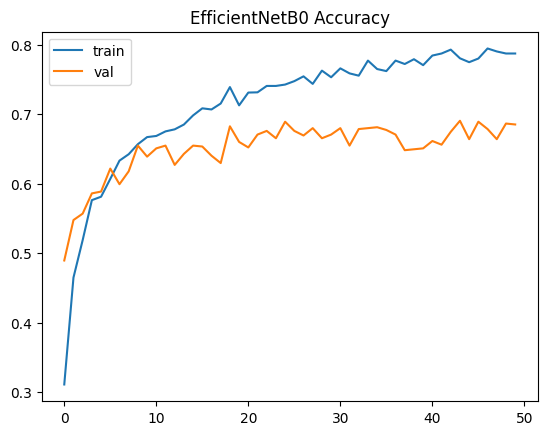

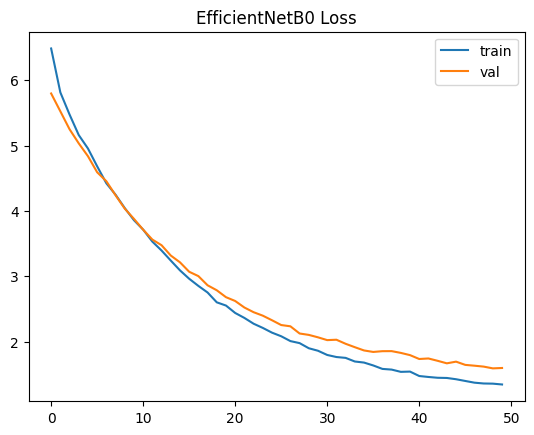

In [22]:
plt.plot(eff_history.history['accuracy'], label='train')
plt.plot(eff_history.history['val_accuracy'], label='val')
plt.title('EfficientNetB0 Accuracy')
plt.legend()
plt.show()

plt.plot(eff_history.history['loss'], label='train')
plt.plot(eff_history.history['val_loss'], label='val')
plt.title('EfficientNetB0 Loss')
plt.legend()
plt.show()

In [23]:
# Train set evaluations
train_eval_flow_eff = augmented_loader.flow_from_directory(
    '/content/recycle_train_resized',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='training',
    shuffle=False
)

train_eval_flow_eff.reset()
true_labels_eff = train_eval_flow_eff.classes
predicted_probs_eff = eff_model.predict(train_eval_flow_eff, verbose=1)
predicted_labels_eff = np.argmax(predicted_probs_eff, axis=1)

print(classification_report(true_labels_eff, predicted_labels_eff, target_names=train_eval_flow_eff.class_indices.keys()))

macro_f1_eff = f1_score(true_labels_eff, predicted_labels_eff, average='macro')
macro_prec_eff = precision_score(true_labels_eff, predicted_labels_eff, average='macro')
macro_recall_eff = recall_score(true_labels_eff, predicted_labels_eff, average='macro')
onehot_eff = np.eye(9)[true_labels_eff]
macro_auc_eff = roc_auc_score(onehot_eff, predicted_probs_eff, multi_class='ovr', average='macro')

print(f'Train F1: {macro_f1_eff:.4f} | Precision: {macro_prec_eff:.4f} | Recall: {macro_recall_eff:.4f} | AUC: {macro_auc_eff:.4f}')

Found 3042 images belonging to 9 classes.
381/381 ━━━━━━━━━━━━━━━━━━━━ 51s 119ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.98      0.97      0.97       295
      2-Food Organics       0.93      0.96      0.95       263
              3-Glass       0.96      0.95      0.96       269
              4-Metal       0.94      0.94      0.94       506
5-Miscellaneous Trash       0.93      0.88      0.90       317
              6-Paper       0.97      0.97      0.97       320
            7-Plastic       0.93      0.94      0.94       589
      8-Textile Trash       0.93      0.96      0.94       204
         9-Vegetation       0.97      0.97      0.97       279

             accuracy                           0.95      3042
            macro avg       0.95      0.95      0.95      3042
         weighted avg       0.95      0.95      0.95      3042

Train F1: 0.9487 | Precision: 0.9489 | Recall: 0.9488 | AUC: 0.9979


In [24]:
# Validation set evaluations
aug_val_flow.reset()
true_labels_eff = aug_val_flow.classes
predicted_probs_eff = eff_model.predict(aug_val_flow, verbose=1)
predicted_labels_eff = np.argmax(predicted_probs_eff, axis=1)

print(classification_report(true_labels_eff, predicted_labels_eff, target_names=aug_val_flow.class_indices.keys()))

macro_f1_eff = f1_score(true_labels_eff, predicted_labels_eff, average='macro')
macro_prec_eff = precision_score(true_labels_eff, predicted_labels_eff, average='macro')
macro_recall_eff = recall_score(true_labels_eff, predicted_labels_eff, average='macro')
onehot_eff = np.eye(9)[true_labels_eff]
macro_auc_eff = roc_auc_score(onehot_eff, predicted_probs_eff, multi_class='ovr', average='macro')

print(f'Val F1: {macro_f1_eff:.4f} | Precision: {macro_prec_eff:.4f} | Recall: {macro_recall_eff:.4f} | AUC: {macro_auc_eff:.4f}')

95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.18      0.10      0.12        73
      2-Food Organics       0.06      0.06      0.06        65
              3-Glass       0.07      0.07      0.07        67
              4-Metal       0.19      0.24      0.21       126
5-Miscellaneous Trash       0.15      0.13      0.14        79
              6-Paper       0.07      0.07      0.07        80
            7-Plastic       0.23      0.19      0.21       147
      8-Textile Trash       0.04      0.06      0.05        50
         9-Vegetation       0.10      0.10      0.10        69

             accuracy                           0.13       756
            macro avg       0.12      0.11      0.11       756
         weighted avg       0.14      0.13      0.13       756

Val F1: 0.1149 | Precision: 0.1204 | Recall: 0.1137 | AUC: 0.5108


In [25]:
# Test set evaluations
res_eval.reset()
true_labels_eff = res_eval.classes
predicted_probs_eff = eff_model.predict(res_eval, verbose=1)
predicted_labels_eff = np.argmax(predicted_probs_eff, axis=1)
print(classification_report(true_labels_eff, predicted_labels_eff, target_names=res_eval.class_indices.keys()))

macro_f1_eff = f1_score(true_labels_eff, predicted_labels_eff, average='macro')
macro_prec_eff = precision_score(true_labels_eff, predicted_labels_eff, average='macro')
macro_recall_eff = recall_score(true_labels_eff, predicted_labels_eff, average='macro')
onehot_eff = np.eye(9)[true_labels_eff]
macro_auc_eff = roc_auc_score(onehot_eff, predicted_probs_eff, multi_class='ovr', average='macro')

print(f'F1: {macro_f1_eff:.4f} | Precision: {macro_prec_eff:.4f} | Recall: {macro_recall_eff:.4f} | AUC: {macro_auc_eff:.4f}')

120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.74      0.71      0.73        93
      2-Food Organics       0.73      0.95      0.83        83
              3-Glass       0.90      0.85      0.87        84
              4-Metal       0.79      0.84      0.82       158
5-Miscellaneous Trash       0.78      0.61      0.68        99
              6-Paper       0.84      0.81      0.82       100
            7-Plastic       0.88      0.78      0.83       185
      8-Textile Trash       0.72      0.81      0.76        64
         9-Vegetation       0.85      0.95      0.90        88

             accuracy                           0.81       954
            macro avg       0.80      0.81      0.80       954
         weighted avg       0.81      0.81      0.81       954

F1: 0.8039 | Precision: 0.8030 | Recall: 0.8128 | AUC: 0.9752


In [26]:
# VGG16
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg_base.layers:
    layer.trainable = False

v = vgg_base.output
v = GlobalAveragePooling2D()(v)
v = BatchNormalization()(v)
v = Dropout(0.3)(v)
v = Dense(256, activation='relu', kernel_regularizer='l2')(v)
v = BatchNormalization()(v)
v = Dropout(0.3)(v)
vgg_out = Dense(9, activation='softmax', kernel_regularizer='l2')(v)

vgg_model = Model(inputs=vgg_base.input, outputs=vgg_out)
vgg_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [27]:
vgg_ckpt = '/content/best_vgg16_augmented_model.h5'

early_stop_vgg = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_save_vgg = ModelCheckpoint(filepath=vgg_ckpt, monitor='val_loss', save_best_only=True)

vgg_history = vgg_model.fit(
    aug_train_flow,
    epochs=50,
    validation_data=aug_val_flow,
    callbacks=[early_stop_vgg, model_save_vgg],
    verbose=1
)

Epoch 1/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.1772 - loss: 6.3813

381/381 ━━━━━━━━━━━━━━━━━━━━ 59s 141ms/step - accuracy: 0.1774 - loss: 6.3804 - val_accuracy: 0.4087 - val_loss: 5.3120
Epoch 2/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.3944 - loss: 5.3681

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.3945 - loss: 5.3680 - val_accuracy: 0.4921 - val_loss: 5.0486
Epoch 3/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.4819 - loss: 5.0432

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.4820 - loss: 5.0430 - val_accuracy: 0.5146 - val_loss: 4.8498
Epoch 4/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5416 - loss: 4.7433

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.5416 - loss: 4.7432 - val_accuracy: 0.5556 - val_loss: 4.6609
Epoch 5/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5559 - loss: 4.5532

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.5560 - loss: 4.5531 - val_accuracy: 0.5701 - val_loss: 4.4689
Epoch 6/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5832 - loss: 4.3895

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.5832 - loss: 4.3894 - val_accuracy: 0.5873 - val_loss: 4.3112
Epoch 7/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6366 - loss: 4.1318

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.6366 - loss: 4.1318 - val_accuracy: 0.5966 - val_loss: 4.1191
Epoch 8/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6449 - loss: 3.9630

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.6449 - loss: 3.9629 - val_accuracy: 0.6019 - val_loss: 3.9916
Epoch 9/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6271 - loss: 3.8332

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.6271 - loss: 3.8331 - val_accuracy: 0.6270 - val_loss: 3.8233
Epoch 10/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6511 - loss: 3.6665

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 130ms/step - accuracy: 0.6511 - loss: 3.6664 - val_accuracy: 0.6217 - val_loss: 3.6668
Epoch 11/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6412 - loss: 3.5350

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.6412 - loss: 3.5349 - val_accuracy: 0.6111 - val_loss: 3.5798
Epoch 12/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6482 - loss: 3.3979

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.6482 - loss: 3.3978 - val_accuracy: 0.6204 - val_loss: 3.4448
Epoch 13/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6501 - loss: 3.2822

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.6502 - loss: 3.2821 - val_accuracy: 0.6124 - val_loss: 3.3340
Epoch 14/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6952 - loss: 3.1046

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.6952 - loss: 3.1046 - val_accuracy: 0.6442 - val_loss: 3.2166
Epoch 15/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6986 - loss: 2.9852

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.6986 - loss: 2.9851 - val_accuracy: 0.6336 - val_loss: 3.1027
Epoch 16/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7096 - loss: 2.8625

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7096 - loss: 2.8625 - val_accuracy: 0.6468 - val_loss: 2.9836
Epoch 17/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6898 - loss: 2.7754

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.6898 - loss: 2.7753 - val_accuracy: 0.6323 - val_loss: 2.9148
Epoch 18/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7115 - loss: 2.6712

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.7115 - loss: 2.6711 - val_accuracy: 0.6468 - val_loss: 2.8094
Epoch 19/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7103 - loss: 2.6166

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7103 - loss: 2.6165 - val_accuracy: 0.6442 - val_loss: 2.6968
Epoch 20/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7079 - loss: 2.5115

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.7080 - loss: 2.5114 - val_accuracy: 0.6534 - val_loss: 2.6232
Epoch 21/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7161 - loss: 2.4464

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7161 - loss: 2.4463 - val_accuracy: 0.6627 - val_loss: 2.5467
Epoch 22/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7268 - loss: 2.3366

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7268 - loss: 2.3365 - val_accuracy: 0.6521 - val_loss: 2.4940
Epoch 23/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7332 - loss: 2.2767

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7332 - loss: 2.2767 - val_accuracy: 0.6455 - val_loss: 2.4303
Epoch 24/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7474 - loss: 2.1652

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7474 - loss: 2.1653 - val_accuracy: 0.6534 - val_loss: 2.3636
Epoch 25/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7364 - loss: 2.1258

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7363 - loss: 2.1258 - val_accuracy: 0.6495 - val_loss: 2.2919
Epoch 26/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7364 - loss: 2.0496

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7364 - loss: 2.0496 - val_accuracy: 0.6548 - val_loss: 2.2378
Epoch 27/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7335 - loss: 2.0140

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7335 - loss: 2.0139 - val_accuracy: 0.6786 - val_loss: 2.1516
Epoch 28/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7257 - loss: 1.9955

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7257 - loss: 1.9955 - val_accuracy: 0.6534 - val_loss: 2.1216
Epoch 29/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7369 - loss: 1.8965

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7370 - loss: 1.8965 - val_accuracy: 0.6601 - val_loss: 2.1064
Epoch 30/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7566 - loss: 1.8448

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7566 - loss: 1.8448 - val_accuracy: 0.6429 - val_loss: 2.0542
Epoch 31/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7556 - loss: 1.8070

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.7556 - loss: 1.8069 - val_accuracy: 0.6614 - val_loss: 2.0057
Epoch 32/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7499 - loss: 1.7531

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7499 - loss: 1.7531 - val_accuracy: 0.6759 - val_loss: 1.9682
Epoch 33/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7602 - loss: 1.7298

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7602 - loss: 1.7297 - val_accuracy: 0.6561 - val_loss: 1.9371
Epoch 34/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7571 - loss: 1.6667

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7571 - loss: 1.6668 - val_accuracy: 0.6720 - val_loss: 1.8928
Epoch 35/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7491 - loss: 1.6690

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.7491 - loss: 1.6690 - val_accuracy: 0.6772 - val_loss: 1.8582
Epoch 36/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7864 - loss: 1.5949

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7864 - loss: 1.5949 - val_accuracy: 0.6786 - val_loss: 1.7990
Epoch 37/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.7429 - loss: 1.6195 - val_accuracy: 0.6746 - val_loss: 1.8126
Epoch 38/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7757 - loss: 1.5576

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7757 - loss: 1.5576 - val_accuracy: 0.6772 - val_loss: 1.7484
Epoch 39/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7716 - loss: 1.5464 - val_accuracy: 0.6667 - val_loss: 1.7495
Epoch 40/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7942 - loss: 1.4822

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.7942 - loss: 1.4822 - val_accuracy: 0.6720 - val_loss: 1.7189
Epoch 41/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7820 - loss: 1.4633

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7820 - loss: 1.4632 - val_accuracy: 0.6759 - val_loss: 1.7056
Epoch 42/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7829 - loss: 1.4409

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7829 - loss: 1.4409 - val_accuracy: 0.6852 - val_loss: 1.6854
Epoch 43/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7737 - loss: 1.4575

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.7737 - loss: 1.4575 - val_accuracy: 0.6733 - val_loss: 1.6747
Epoch 44/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7731 - loss: 1.4226

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7731 - loss: 1.4226 - val_accuracy: 0.6680 - val_loss: 1.6573
Epoch 45/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7847 - loss: 1.3947

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.7846 - loss: 1.3947 - val_accuracy: 0.6442 - val_loss: 1.6427
Epoch 46/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7978 - loss: 1.3648

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7978 - loss: 1.3648 - val_accuracy: 0.6852 - val_loss: 1.5922
Epoch 47/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7881 - loss: 1.3668

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.7881 - loss: 1.3668 - val_accuracy: 0.6746 - val_loss: 1.5762
Epoch 48/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.7854 - loss: 1.3426 - val_accuracy: 0.6720 - val_loss: 1.5769
Epoch 49/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7770 - loss: 1.3454

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.7770 - loss: 1.3453 - val_accuracy: 0.6759 - val_loss: 1.5732
Epoch 50/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7838 - loss: 1.3161

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.7838 - loss: 1.3161 - val_accuracy: 0.6825 - val_loss: 1.5373


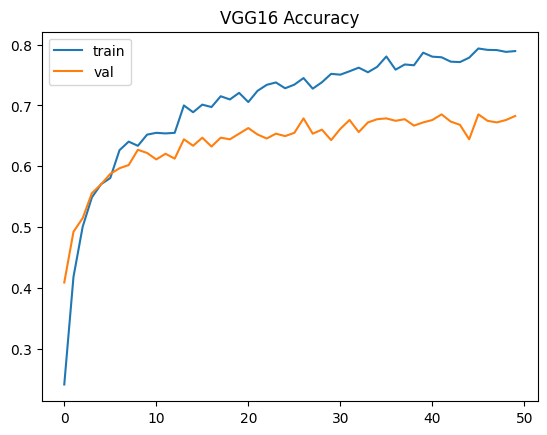

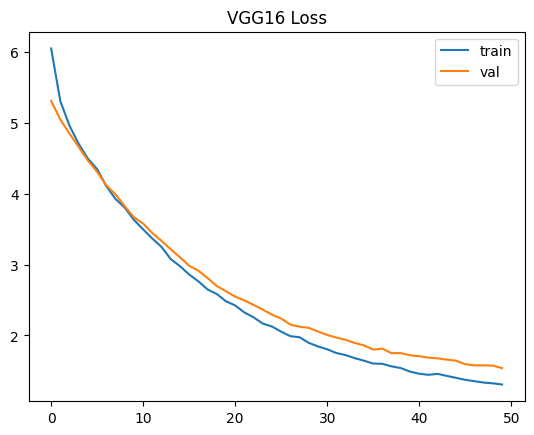

In [28]:
plt.plot(vgg_history.history['accuracy'], label='train')
plt.plot(vgg_history.history['val_accuracy'], label='val')
plt.title('VGG16 Accuracy')
plt.legend()
plt.show()

plt.plot(vgg_history.history['loss'], label='train')
plt.plot(vgg_history.history['val_loss'], label='val')
plt.title('VGG16 Loss')
plt.legend()
plt.show()

In [29]:
# Train set evaluations
train_eval_flow_vgg = augmented_loader.flow_from_directory(
    '/content/recycle_train_resized',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='training',
    shuffle=False
)

train_eval_flow_vgg.reset()
true_labels_vgg = train_eval_flow_vgg.classes
predicted_probs_vgg = vgg_model.predict(train_eval_flow_vgg, verbose=1)
predicted_labels_vgg = np.argmax(predicted_probs_vgg, axis=1)

print(classification_report(true_labels_vgg, predicted_labels_vgg, target_names=train_eval_flow_vgg.class_indices.keys()))

macro_f1_vgg = f1_score(true_labels_vgg, predicted_labels_vgg, average='macro')
macro_prec_vgg = precision_score(true_labels_vgg, predicted_labels_vgg, average='macro')
macro_recall_vgg = recall_score(true_labels_vgg, predicted_labels_vgg, average='macro')
onehot_vgg = np.eye(9)[true_labels_vgg]
macro_auc_vgg = roc_auc_score(onehot_vgg, predicted_probs_vgg, multi_class='ovr', average='macro')

print(f'Train F1: {macro_f1_vgg:.4f} | Precision: {macro_prec_vgg:.4f} | Recall: {macro_recall_vgg:.4f} | AUC: {macro_auc_vgg:.4f}')

Found 3042 images belonging to 9 classes.
381/381 ━━━━━━━━━━━━━━━━━━━━ 40s 103ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.97      0.93      0.95       295
      2-Food Organics       0.96      0.94      0.95       263
              3-Glass       0.93      0.90      0.91       269
              4-Metal       0.92      0.93      0.93       506
5-Miscellaneous Trash       0.90      0.84      0.87       317
              6-Paper       0.94      0.95      0.94       320
            7-Plastic       0.90      0.94      0.92       589
      8-Textile Trash       0.92      0.93      0.92       204
         9-Vegetation       0.93      0.97      0.95       279

             accuracy                           0.93      3042
            macro avg       0.93      0.92      0.93      3042
         weighted avg       0.93      0.93      0.93      3042

Train F1: 0.9265 | Precision: 0.9292 | Recall: 0.9244 | AUC: 0.9962


In [30]:
# Validation set evaluations
aug_val_flow.reset()
true_labels_vgg = aug_val_flow.classes
predicted_probs_vgg = vgg_model.predict(aug_val_flow, verbose=1)
predicted_labels_vgg = np.argmax(predicted_probs_vgg, axis=1)

print(classification_report(true_labels_vgg, predicted_labels_vgg, target_names=aug_val_flow.class_indices.keys()))

macro_f1_vgg = f1_score(true_labels_vgg, predicted_labels_vgg, average='macro')
macro_prec_vgg = precision_score(true_labels_vgg, predicted_labels_vgg, average='macro')
macro_recall_vgg = recall_score(true_labels_vgg, predicted_labels_vgg, average='macro')
onehot_vgg = np.eye(9)[true_labels_vgg]
macro_auc_vgg = roc_auc_score(onehot_vgg, predicted_probs_vgg, multi_class='ovr', average='macro')

print(f'Val F1: {macro_f1_vgg:.4f} | Precision: {macro_prec_vgg:.4f} | Recall: {macro_recall_vgg:.4f} | AUC: {macro_auc_vgg:.4f}')

95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.12      0.07      0.09        73
      2-Food Organics       0.05      0.05      0.05        65
              3-Glass       0.15      0.16      0.15        67
              4-Metal       0.18      0.20      0.19       126
5-Miscellaneous Trash       0.10      0.11      0.11        79
              6-Paper       0.04      0.04      0.04        80
            7-Plastic       0.21      0.20      0.20       147
      8-Textile Trash       0.10      0.12      0.11        50
         9-Vegetation       0.04      0.04      0.04        69

             accuracy                           0.12       756
            macro avg       0.11      0.11      0.11       756
         weighted avg       0.12      0.12      0.12       756

Val F1: 0.1085 | Precision: 0.1096 | Recall: 0.1099 | AUC: 0.4967


In [31]:
# Test set evaluations
res_eval.reset()
true_labels_vgg = res_eval.classes
predicted_probs_vgg = vgg_model.predict(res_eval, verbose=1)
predicted_labels_vgg = np.argmax(predicted_probs_vgg, axis=1)
print(classification_report(true_labels_vgg, predicted_labels_vgg, target_names=res_eval.class_indices.keys()))

macro_f1_vgg = f1_score(true_labels_vgg, predicted_labels_vgg, average='macro')
macro_prec_vgg = precision_score(true_labels_vgg, predicted_labels_vgg, average='macro')
macro_recall_vgg = recall_score(true_labels_vgg, predicted_labels_vgg, average='macro')
onehot_vgg = np.eye(9)[true_labels_vgg]
macro_auc_vgg = roc_auc_score(onehot_vgg, predicted_probs_vgg, multi_class='ovr', average='macro')

print(f'F1: {macro_f1_vgg:.4f} | Precision: {macro_prec_vgg:.4f} | Recall: {macro_recall_vgg:.4f} | AUC: {macro_auc_vgg:.4f}')

120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.75      0.69      0.72        93
      2-Food Organics       0.86      0.87      0.86        83
              3-Glass       0.80      0.79      0.79        84
              4-Metal       0.75      0.85      0.80       158
5-Miscellaneous Trash       0.81      0.63      0.70        99
              6-Paper       0.86      0.77      0.81       100
            7-Plastic       0.74      0.79      0.77       185
      8-Textile Trash       0.78      0.78      0.78        64
         9-Vegetation       0.93      0.99      0.96        88

             accuracy                           0.80       954
            macro avg       0.81      0.79      0.80       954
         weighted avg       0.80      0.80      0.79       954

F1: 0.7986 | Precision: 0.8071 | Recall: 0.7945 | AUC: 0.9747


In [32]:
# Comparison summary
acc_resnet50 = np.mean(predicted_labels == true_labels)
acc_resnet101 = np.mean(predicted_labels_101 == true_labels_101)
acc_efficientnet = np.mean(predicted_labels_eff == true_labels_eff)
acc_vgg16 = np.mean(predicted_labels_vgg == true_labels_vgg)

summary_df = pd.DataFrame({
    'Model': ['ResNet50', 'ResNet101', 'EfficientNetB0', 'VGG16'],
    'Accuracy': [acc_resnet50, acc_resnet101, acc_efficientnet, acc_vgg16],
    'Precision': [macro_prec, macro_prec_101, macro_prec_eff, macro_prec_vgg],
    'Recall': [macro_recall, macro_recall_101, macro_recall_eff, macro_recall_vgg],
    'F1 Score': [macro_f1, macro_f1_101, macro_f1_eff, macro_f1_vgg],
    'AUC': [macro_auc, macro_auc_101, macro_auc_eff, macro_auc_vgg]
}).round(4).set_index('Model')

summary_df

,Accuracy,Precision,Recall,F1 Score,AUC
Model,,,,,
ResNet50,0.8616,0.8688,0.8655,0.8658,0.9866
ResNet101,0.8732,0.8844,0.8718,0.8760,0.9884
EfficientNetB0,0.8082,0.8030,0.8128,0.8039,0.9752
VGG16,0.7956,0.8071,0.7945,0.7986,0.9747


I evaluated the performance of four pre-trained convolutional neural networks—ResNet50, ResNet101, EfficientNetB0, and VGG16—on a multi-class waste classification task using frozen feature extractors and custom classification heads. ResNet101 delivered the best overall results, achieving a test accuracy of 87.32% and an AUC of 0.9884, with strong precision, recall, and F1 scores. ResNet50 performed comparably well, while EfficientNetB0 and VGG16 also showed solid results, both surpassing 79% test accuracy after applying model-specific preprocessing, label smoothing, and regularization. These improvements underscore the importance of architectural choices and fine-grained tuning techniques. Further gains could likely be achieved by unfreezing select layers for fine-tuning or experimenting with learning rate schedules.

> Below commands can be ignored, just utils.

In [ ]:
# Meta Data Transfer - To GDrive
# !cp -r /content/recycle_train_resized /content/drive/MyDrive/DSML_Project/meta_data/
# !cp -r /content/recycle_test_resized /content/drive/MyDrive/DSML_Project/meta_data/
# !cp -r /content/recycle_trainset /content/drive/MyDrive/DSML_Project/meta_data/
# !cp -r /content/recycle_testset /content/drive/MyDrive/DSML_Project/meta_data/

In [ ]:
# Meta Data Transfer - From GDrive
# !cp -r /content/drive/MyDrive/DSML_Project/meta_data/recycle_train_resized/ /content/
# !cp -r /content/drive/MyDrive/DSML_Project/meta_data/recycle_test_resized /content/
# !cp -r /content/drive/MyDrive/DSML_Project/meta_data/recycle_trainset/ /content/
# !cp -r /content/drive/MyDrive/DSML_Project/meta_data/recycle_testset/ /content/